# Предсказание активности покупателей интернет-магазинов

## Описание:
* В нашем распоряжении информация по трем интернет-магазинам: мультикатегорийный магазин с посещаемостью более 8 млн сессий в месяц, магазин одежды, маленький магазин подарков. В них есть обезличенная история покупок клиентов за определенный период

## Цель:
* Создать решение для предсказания, совершит ли покупатель повторную покупку в течение ближайших 30 дней

## Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from pathlib import Path
import phik

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, recall_score, f1_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

RANDOM_STATE = 945

In [2]:
apparel = pd.read_csv(
    "data/apparel-purchases.csv", parse_dates=[3])
display(apparel)

gifts = pd.read_csv(
    "data/gifts-purchases.csv", parse_dates=[3])
display(gifts)

marketplace = pd.read_csv(
    "data/marketplace-purchases.csv", parse_dates=[4,5])
display(marketplace)

,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
...,...,...,...,...,...,...
133099,1515915625909375164,1,2399.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message
133100,1515915625909375164,1,2399.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message
133101,1515915625909375164,1,1699.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message
133102,1515915625909375164,1,1699.0,2022-12-31,1515915625490956133-9110-63ae8ee3e5e7f,bulk_message


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
...,...,...,...,...,...,...
806,1515915625870025628,1,39992.0,2022-11-28,1515915625867543212-8163-6383352a4f29f,bulk_message
807,1515915625873498326,1,3035.0,2022-11-23,1515915625873498326-8044-637ccf9a38a17,bulk_message
808,1515915625873498326,1,3035.0,2022-11-23,1515915625873498326-8044-637ccf9a38a17,bulk_message
809,1515915625878133961,1,3442.0,2022-11-26,1515915625866862784-8170-6380c36047d7f,bulk_message


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52
...,...,...,...,...,...,...
48177,1515915625575803144,1,29998.0,1515915625520976171-1747-644b87709eac8,2023-04-29,2023-04-29 11:19:29
48178,1515915625575803144,1,29998.0,1515915625520976171-1747-644b87709eac8,2023-04-29,2023-04-29 11:19:29
48179,1515915625575808251,1,25998.0,1515915625542646315-1748-644b600b9435d,2023-04-29,2023-04-29 11:46:30
48180,1515915625575809442,1,15998.0,1515915625518408482-1747-644b876fe63e6,2023-04-29,2023-04-29 08:48:11


## gifts

In [3]:
print(f"Количество уникальных id: {gifts['client_id'].nunique()} из {gifts.shape[0]} записей")

Количество уникальных id: 326 из 811 записей


Необходимо посмотреть насколько нужна нам колонка содержащие источник рекомендаций, потому что если там всего один источник у всех клиентов, то это совершенно бессмысленный столбец для нашей задачи и его можно удалить. 

In [4]:
display(gifts['recommended_by'].unique())

display(gifts['recommended_by'].isna().sum())

display(gifts['date'].min(), gifts['date'].max())

array(['bulk_message'], dtype=object)

0

Timestamp('2022-10-26 00:00:00')

Timestamp('2023-10-24 00:00:00')

Я считаю, что клиент совершивший покупку в одну дату, неважно сколько записей соответствует этому клиенту в эту дату, это клиент совершивший одну покупку. Поэтому я просто просуммирую количество объектов в каждой записи и сумму покупки.

In [5]:
print(f"Количество дубликатов до агрегации: {gifts.duplicated().sum()}")

gifts = gifts.groupby(['client_id', 'date']).agg({'price': 'sum',
                                                 'quantity': 'sum'}).reset_index()
gifts = gifts.sort_values(by=['client_id', 'date'])

print(f"Количество дубликатов после агрегации: {gifts.duplicated().sum()}")

display(gifts)

Количество дубликатов до агрегации: 56
Количество дубликатов после агрегации: 0


,client_id,date,price,quantity
0,1515915625803180506,2023-06-27,33961.0,3
1,1515915625803180756,2023-03-01,5990.0,1
2,1515915625803180771,2023-06-16,4824.0,1
3,1515915625803180879,2023-06-29,43152.0,8
4,1515915625803207150,2023-02-25,5980.0,2
...,...,...,...,...
362,1515915626005014483,2023-09-13,7534.0,1
363,1515915626010039507,2023-10-02,26039.0,2
364,1515915626011484905,2023-10-13,32913.0,5
365,1515915626012131867,2023-09-12,25834.0,1


In [6]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   client_id  367 non-null    int64         
 1   date       367 non-null    datetime64[ns]
 2   price      367 non-null    float64       
 3   quantity   367 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 14.3 KB


Напишу функцию для создания новых признаков

In [7]:
def new_features(df):
    
    df['weekday'] = df['date'].dt.dayofweek

    df['month'] = df['date'].dt.month

    df['count'] = df.groupby('client_id')['client_id'].transform('count')
    
    df['cum_sum'] = df.groupby('client_id')['price'].transform('cumsum')

    df['min_sum'] = df.groupby('client_id')['price'].transform('min')
    
    df['next_order_date'] = df.groupby('client_id')['date'].transform(lambda x: x.shift(-1))  

    df['days_to_next_purch'] = df.groupby('client_id')['date'].transform\
    (lambda x: (x.shift(-1) - x).dt.days)

    return df

In [8]:
display(new_features(gifts))

,client_id,date,price,quantity,weekday,month,count,cum_sum,min_sum,next_order_date,days_to_next_purch
0,1515915625803180506,2023-06-27,33961.0,3,1,6,1,33961.0,33961.0,NaT,NaN
1,1515915625803180756,2023-03-01,5990.0,1,2,3,1,5990.0,5990.0,NaT,NaN
2,1515915625803180771,2023-06-16,4824.0,1,4,6,1,4824.0,4824.0,NaT,NaN
3,1515915625803180879,2023-06-29,43152.0,8,3,6,1,43152.0,43152.0,NaT,NaN
4,1515915625803207150,2023-02-25,5980.0,2,5,2,1,5980.0,5980.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
362,1515915626005014483,2023-09-13,7534.0,1,2,9,1,7534.0,7534.0,NaT,NaN
363,1515915626010039507,2023-10-02,26039.0,2,0,10,1,26039.0,26039.0,NaT,NaN
364,1515915626011484905,2023-10-13,32913.0,5,4,10,1,32913.0,32913.0,NaT,NaN
365,1515915626012131867,2023-09-12,25834.0,1,1,9,1,25834.0,25834.0,NaT,NaN


## apparel

In [9]:
apparel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


In [10]:
print(f"Количество уникальных id: {apparel['client_id'].nunique()} из {apparel.shape[0]} записей")

Количество уникальных id: 28891 из 133104 записей


In [11]:
display(apparel['recommended_by'].nunique())

display(apparel['recommended_by'].isna().sum())

1

0

In [12]:
print(f"Количество дубликатов до агрегации: {apparel.duplicated().sum()}")

apparel = apparel.groupby(['client_id', 'date']).agg({'price': 'sum',
                                                 'quantity': 'sum'}).reset_index()
apparel = apparel.sort_values(by=['client_id', 'date'])

print(f"Количество дубликатов после агрегации: {apparel.duplicated().sum()}")

display(apparel)

Количество дубликатов до агрегации: 59250
Количество дубликатов после агрегации: 0


,client_id,date,price,quantity
0,1515915625468061003,2023-01-04,16235.0,7
1,1515915625468061170,2023-03-26,5412.0,4
2,1515915625468061170,2023-03-29,25192.0,12
3,1515915625468061170,2023-06-17,2997.0,3
4,1515915625468061994,2022-11-15,199.0,1
...,...,...,...,...
33214,1515915625998152414,2023-10-12,3210.0,8
33215,1515915625998380048,2023-10-14,4499.0,1
33216,1515915625998392034,2023-10-17,5036.0,6
33217,1515915625998917545,2023-10-23,198.0,2


In [13]:
display(new_features(apparel))

,client_id,date,price,quantity,weekday,month,count,cum_sum,min_sum,next_order_date,days_to_next_purch
0,1515915625468061003,2023-01-04,16235.0,7,2,1,1,16235.0,16235.0,NaT,NaN
1,1515915625468061170,2023-03-26,5412.0,4,6,3,3,5412.0,2997.0,2023-03-29,3.0
2,1515915625468061170,2023-03-29,25192.0,12,2,3,3,30604.0,2997.0,2023-06-17,80.0
3,1515915625468061170,2023-06-17,2997.0,3,5,6,3,33601.0,2997.0,NaT,NaN
4,1515915625468061994,2022-11-15,199.0,1,1,11,2,199.0,199.0,2022-12-14,29.0
...,...,...,...,...,...,...,...,...,...,...,...
33214,1515915625998152414,2023-10-12,3210.0,8,3,10,1,3210.0,3210.0,NaT,NaN
33215,1515915625998380048,2023-10-14,4499.0,1,5,10,1,4499.0,4499.0,NaT,NaN
33216,1515915625998392034,2023-10-17,5036.0,6,1,10,1,5036.0,5036.0,NaT,NaN
33217,1515915625998917545,2023-10-23,198.0,2,0,10,1,198.0,198.0,NaT,NaN


## marketplace

In [14]:
print(f"Количество уникальных id: {marketplace['client_id'].nunique()} из {marketplace.shape[0]} записей")

Количество уникальных id: 17787 из 48182 записей


In [15]:
print(f"Количество дубликатов до агрегации: {marketplace.duplicated().sum()}")

marketplace = marketplace.groupby(['client_id', 'date']).agg({'price': 'sum',
                                                 'quantity': 'sum'}).reset_index()
marketplace = marketplace.sort_values(by=['client_id', 'date'])

print(f"Количество дубликатов после агрегации: {marketplace.duplicated().sum()}")

display(marketplace)

Количество дубликатов до агрегации: 2159
Количество дубликатов после агрегации: 0


,client_id,date,price,quantity
0,1515915625440099873,2023-07-16 08:25:31,31998.0,1
1,1515915625440099873,2023-08-09 08:59:08,1218.0,1
2,1515915625440939402,2023-01-30 13:13:37,75998.0,1
3,1515915625440944408,2023-03-01 10:21:12,882.0,1
4,1515915625440944408,2023-05-02 08:49:57,6298.0,1
...,...,...,...,...
31985,1515915625588554419,2023-10-24 09:22:59,6398.0,1
31986,1515915625588559168,2023-10-24 10:28:29,132886.0,7
31987,1515915625588573679,2023-10-24 13:58:17,59998.0,1
31988,1515915625588627186,2023-10-25 10:04:22,16998.0,1


In [16]:
display(new_features(marketplace))

,client_id,date,price,quantity,weekday,month,count,cum_sum,min_sum,next_order_date,days_to_next_purch
0,1515915625440099873,2023-07-16 08:25:31,31998.0,1,6,7,2,31998.0,1218.0,2023-08-09 08:59:08,24.0
1,1515915625440099873,2023-08-09 08:59:08,1218.0,1,2,8,2,33216.0,1218.0,NaT,NaN
2,1515915625440939402,2023-01-30 13:13:37,75998.0,1,0,1,1,75998.0,75998.0,NaT,NaN
3,1515915625440944408,2023-03-01 10:21:12,882.0,1,2,3,3,882.0,882.0,2023-05-02 08:49:57,61.0
4,1515915625440944408,2023-05-02 08:49:57,6298.0,1,1,5,3,7180.0,882.0,2023-06-21 12:20:06,50.0
...,...,...,...,...,...,...,...,...,...,...,...
31985,1515915625588554419,2023-10-24 09:22:59,6398.0,1,1,10,1,6398.0,6398.0,NaT,NaN
31986,1515915625588559168,2023-10-24 10:28:29,132886.0,7,1,10,1,132886.0,132886.0,NaT,NaN
31987,1515915625588573679,2023-10-24 13:58:17,59998.0,1,1,10,1,59998.0,59998.0,NaT,NaN
31988,1515915625588627186,2023-10-25 10:04:22,16998.0,1,2,10,1,16998.0,16998.0,NaT,NaN


## Объединенный датасет

Помечу источник данных в каждом датасете и объединю их

In [17]:
apparel['source'] = 0
gifts['source'] = 1
marketplace['source'] = 2

data = pd.concat([apparel, gifts, marketplace])

display(data)

,client_id,date,price,quantity,weekday,month,count,cum_sum,min_sum,next_order_date,days_to_next_purch,source
0,1515915625468061003,2023-01-04 00:00:00,16235.0,7,2,1,1,16235.0,16235.0,NaT,NaN,0
1,1515915625468061170,2023-03-26 00:00:00,5412.0,4,6,3,3,5412.0,2997.0,2023-03-29,3.0,0
2,1515915625468061170,2023-03-29 00:00:00,25192.0,12,2,3,3,30604.0,2997.0,2023-06-17,80.0,0
3,1515915625468061170,2023-06-17 00:00:00,2997.0,3,5,6,3,33601.0,2997.0,NaT,NaN,0
4,1515915625468061994,2022-11-15 00:00:00,199.0,1,1,11,2,199.0,199.0,2022-12-14,29.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
31985,1515915625588554419,2023-10-24 09:22:59,6398.0,1,1,10,1,6398.0,6398.0,NaT,NaN,2
31986,1515915625588559168,2023-10-24 10:28:29,132886.0,7,1,10,1,132886.0,132886.0,NaT,NaN,2
31987,1515915625588573679,2023-10-24 13:58:17,59998.0,1,1,10,1,59998.0,59998.0,NaT,NaN,2
31988,1515915625588627186,2023-10-25 10:04:22,16998.0,1,2,10,1,16998.0,16998.0,NaT,NaN,2


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65576 entries, 0 to 31989
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   client_id           65576 non-null  int64         
 1   date                65576 non-null  datetime64[ns]
 2   price               65576 non-null  float64       
 3   quantity            65576 non-null  int64         
 4   weekday             65576 non-null  int64         
 5   month               65576 non-null  int64         
 6   count               65576 non-null  int64         
 7   cum_sum             65576 non-null  float64       
 8   min_sum             65576 non-null  float64       
 9   next_order_date     18572 non-null  datetime64[ns]
 10  days_to_next_purch  18572 non-null  float64       
 11  source              65576 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(6)
memory usage: 6.5 MB


# Модель

Пометим данные по условию что дней от 1 до 30 до следующей покупки если она была. 

In [19]:
data['target'] = data['days_to_next_purch'].apply(lambda x: 1 if 0 < x <= 30 else 0)
    
display(data.head())

,client_id,date,price,quantity,weekday,month,count,cum_sum,min_sum,next_order_date,days_to_next_purch,source,target
0,1515915625468061003,2023-01-04,16235.0,7,2,1,1,16235.0,16235.0,NaT,NaN,0,0
1,1515915625468061170,2023-03-26,5412.0,4,6,3,3,5412.0,2997.0,2023-03-29,3.0,0,1
2,1515915625468061170,2023-03-29,25192.0,12,2,3,3,30604.0,2997.0,2023-06-17,80.0,0,0
3,1515915625468061170,2023-06-17,2997.0,3,5,6,3,33601.0,2997.0,NaT,NaN,0,0
4,1515915625468061994,2022-11-15,199.0,1,1,11,2,199.0,199.0,2022-12-14,29.0,0,1


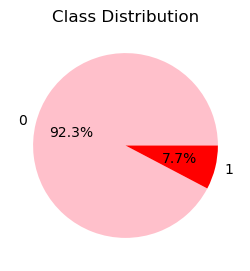

In [20]:
plt.figure(figsize=(3, 3))
data['target'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['pink', 'red'])
plt.title('Class Distribution')
plt.ylabel('')
plt.show();

Помимо этого еще необходимо убрать данные для которых невозможно предсказать таргет, то есть последняя дата минус 30 дней.

In [21]:
data = data.loc[data['date'] <= (data['date'].max() - pd.Timedelta(days=30))]

display(data.head())

display(data.shape)

,client_id,date,price,quantity,weekday,month,count,cum_sum,min_sum,next_order_date,days_to_next_purch,source,target
0,1515915625468061003,2023-01-04,16235.0,7,2,1,1,16235.0,16235.0,NaT,NaN,0,0
1,1515915625468061170,2023-03-26,5412.0,4,6,3,3,5412.0,2997.0,2023-03-29,3.0,0,1
2,1515915625468061170,2023-03-29,25192.0,12,2,3,3,30604.0,2997.0,2023-06-17,80.0,0,0
3,1515915625468061170,2023-06-17,2997.0,3,5,6,3,33601.0,2997.0,NaT,NaN,0,0
4,1515915625468061994,2022-11-15,199.0,1,1,11,2,199.0,199.0,2022-12-14,29.0,0,1


(61487, 13)

In [22]:
data['date'].max()

Timestamp('2023-09-26 13:29:02')

Удаляю колонки которые нам больше не нужны для обучения моделей

In [23]:
data = data.drop(['next_order_date', 'days_to_next_purch', 'date'], axis=1)

## бейзлайн

In [24]:
data.columns

Index(['client_id', 'price', 'quantity', 'weekday', 'month', 'count',
       'cum_sum', 'min_sum', 'source', 'target'],
      dtype='object')

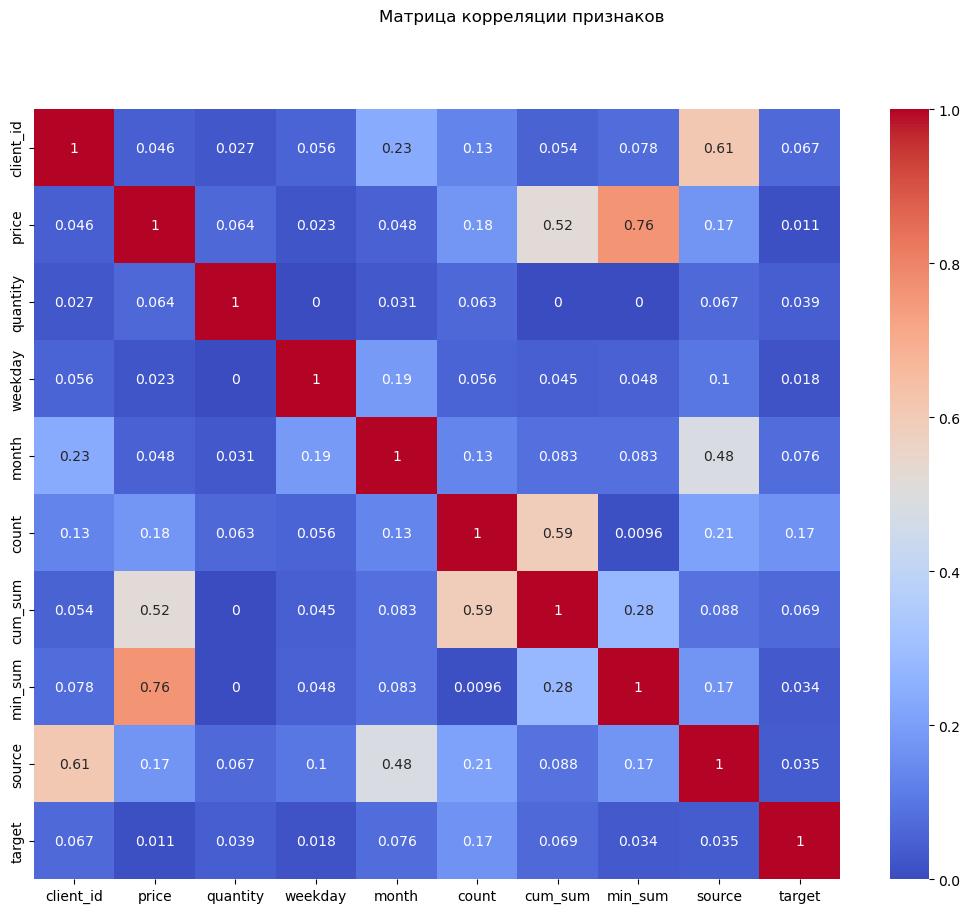

In [25]:
int_cols = ['client_id', 'price', 'quantity', 'count',\
       'cum_sum', 'min_sum']

matrix = data.phik_matrix(interval_cols=int_cols)
plt.figure(figsize=(13,10))
plt.suptitle('Матрица корреляции признаков')
sns.heatmap(matrix, cmap="coolwarm", annot=True)
plt.show();

По матрице корреляций видно что айди клиента зависит от источника данных, то есть видимо в айди вшита информация о том из какого магазина пришли данные. Также как и месяц покупки тоже немного зависит от источника. Ну и что закономерно что кумулятивная сумма зависит от того сколько раз клиент приеходил в магазин и совершал покупку.

In [26]:
kfold = KFold(n_splits=10, shuffle=True)

train, other = train_test_split(data, test_size=0.2, stratify=data['target'])
valid, test = train_test_split(other, test_size=0.5, stratify=other['target'])

f_train = train.drop('target', axis=1)
t_train = train['target']

f_valid = valid.drop('target', axis=1)
t_valid = valid['target']

f_test = test.drop('target', axis=1)
t_test = test['target']

In [27]:
f_train.columns

Index(['client_id', 'price', 'quantity', 'weekday', 'month', 'count',
       'cum_sum', 'min_sum', 'source'],
      dtype='object')

Проверяем базовую модель и будем ориентироваться на эти метрики

In [28]:
baseline = DummyClassifier(strategy="stratified")

scoring = ['recall', 'f1', 'roc_auc']
cv_results = cross_validate(baseline, f_train, t_train, cv=kfold, scoring=scoring, n_jobs=-1)

print("Mean F1 Score:", cv_results['test_f1'].mean().round(2))
print("Mean roc_auc:", cv_results['test_roc_auc'].mean().round(2))
print("Mean Recall:", cv_results['test_recall'].mean().round(2))

Mean F1 Score: 0.08
Mean roc_auc: 0.5
Mean Recall: 0.08


## XGBClassifier

In [29]:
xgbc = XGBClassifier()

param_grid_xgbc = {
    'n_estimators': [150, 300, 500],
    'learning_rate': [0.2, 0.01],
    'max_depth': [15, 30, 40],
    'objective': ['binary:logistic']
}


grid_search_xgbc = GridSearchCV(estimator=xgbc, \
                           param_grid=param_grid_xgbc, cv=kfold, scoring='f1')

grid_search_xgbc.fit(f_train, t_train)

print('XGBClassifier f1: %.2f'% grid_search_xgbc.best_score_)
print(f'XGBClassifier параметры: {grid_search_xgbc.best_estimator_}')

print('\nXGBClassifier f1 на val выборке: %.2f'% \
      f1_score(t_valid, grid_search_xgbc.predict(f_valid)))

print('XGBClassifier roc_auc на val выборке: %.2f'% \
      roc_auc_score(t_valid, grid_search_xgbc.predict_proba(f_valid)[:, 1]))

print('XGBClassifier recall на val выборке: %.2f'% \
      recall_score(t_valid, grid_search_xgbc.predict(f_valid)))

XGBClassifier f1: 0.34
XGBClassifier параметры: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

XGBClassifier f1 на val выборке: 0.37
XGBClassifier roc_auc на val выборке: 0.91
XGBClassifier recall на val выборке: 0.30


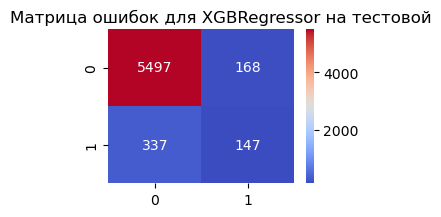

In [30]:
conf_mtx = confusion_matrix(t_valid, grid_search_xgbc.predict(f_valid))

np.set_printoptions(suppress=True)
plt.figure(figsize=(3, 2))
plt.suptitle('Матрица ошибок для XGBRegressor на тестовой')
sns.heatmap(conf_mtx, cmap="coolwarm", annot=True, fmt='d')
plt.show();

## LGBMClassifier

In [31]:
lgbmm = lgb.LGBMClassifier()

param_grid_lgb = {
    'n_estimators': [150, 300, 500],
    'learning_rate': [0.2, 0.01],
    'max_depth': [10, 6, 7, 8, 9],
    'num_leaves': [15, 30],
    'objective': ['binary'],
    'min_child_samples': [10, 20]
}


grid_search_lgb = GridSearchCV(estimator=lgbmm, \
                           param_grid=param_grid_lgb, cv=kfold, scoring='f1')

grid_search_lgb.fit(f_train, t_train)

print('LGBMClassifier f1: %.2f'% grid_search_lgb.best_score_)
print(f'LGBMClassifier параметры: {grid_search_lgb.best_estimator_}')

print('LGBMClassifier f1 на val выборке: %.2f'% \
      f1_score(t_valid, grid_search_lgb.predict(f_valid)))

print('LGBMClassifier roc_auc на val выборке: %.2f'% \
      roc_auc_score(t_valid, grid_search_lgb.predict_proba(f_valid)[:, 1]))

print('LGBMClassifier recall на val выборке: %.2f'% \
      recall_score(t_valid, grid_search_lgb.predict(f_valid)))

LGBMClassifier f1: 0.31
LGBMClassifier параметры: LGBMClassifier(learning_rate=0.2, max_depth=6, n_estimators=500, num_leaves=30,
               objective='binary')
LGBMClassifier f1 на val выборке: 0.31
LGBMClassifier roc_auc на val выборке: 0.91
LGBMClassifier recall на val выборке: 0.23


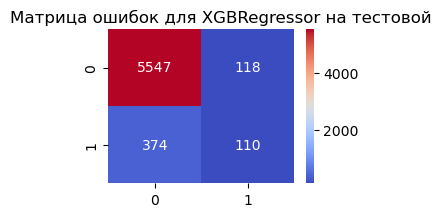

In [32]:
conf_mtx = confusion_matrix(t_valid, grid_search_lgb.predict(f_valid))

np.set_printoptions(formatter={'float': '{:0.0f}'.format})
np.set_printoptions(suppress=True)
plt.figure(figsize=(3, 2))
plt.suptitle('Матрица ошибок для XGBRegressor на тестовой')
sns.heatmap(conf_mtx, cmap="coolwarm", annot=True, fmt='d')
plt.show();

## test

Исходя из комплекса этих трех метрик я посчитала, что модель XGBClassifier лучше справилась с задачей и проверять тестовую выборку стоит именно на ней

ROC-AUC:  0.92
Recall: 0.29
F1 Score:0.35


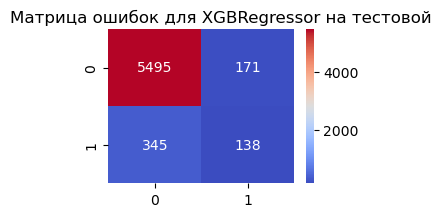

In [33]:
print('ROC-AUC:  %.2f'% roc_auc_score(t_test, grid_search_xgbc.predict_proba(f_test)[:, 1]))
print('Recall: %.2f'% recall_score(t_test, grid_search_xgbc.predict(f_test)))
print('F1 Score:%.2f'% f1_score(t_test, grid_search_xgbc.predict(f_test)))

conf_mtx = confusion_matrix(t_test, grid_search_xgbc.predict(f_test))
np.set_printoptions(suppress=True)
plt.figure(figsize=(3, 2))
plt.suptitle('Матрица ошибок для XGBRegressor на тестовой')
sns.heatmap(conf_mtx, cmap="coolwarm", annot=True, fmt='d')
plt.show();

Кажется, как будто результат через матрицу не очень хороший, но на самом деле с таким дисбалансом классов может и вполне валидный. Понятно что TN предсказывается хорошо, но странно что модель предсказывает FP предсказала больше, чем TP. 

# Заключение

* Оставив только айди клиента, дату и цену с количеством купленных предметов можно сгенерировать такие признаки, которые в целом могут обеспечить неплохой уровень метрик на валидационной выборке
* при решении задачи я исходила из того, что в датасетах нет настоящих дубликатов, это просто записи покупках одного клиента в один день с товарами разных артикулов и в целом такой подход скорее оправдал себя
* очень долго не могла понять почему все мои метрики у всех моделей кроме базовой показывают единицы, только потом увидела, что перед подачей в модель не удалила признак количества дней до следующей покупки, который понятно напряму связан с таргетом, поэтому модели все предсказывали идеально
* на тестовой выборке метрики вышли следующими:
    - ROC-AUC:  0.92
    - Recall: 0.29
    - F1 Score:0.35